In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
import yaml

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [86]:
PARAMS_PATH = "../params.yaml"
with open(PARAMS_PATH) as f:
    config = yaml.safe_load(f)

# 1 Load data

In [87]:
RAW_DATA_PATH = config["data_load"]["raw"]
data = pd.read_csv(RAW_DATA_PATH)
assert isinstance(data, pd.DataFrame)

In [88]:
max_year = data["year"].max()
data = data[data["year"] == (max_year - 2)]
assert data["year"].min() == (max_year - 2)

In [89]:
FEATURES = ["sqft", "county", "baths", "beds"]
TARGET = ["price"]
COLUMNS = [*TARGET, *FEATURES]

data = data[COLUMNS]
assert data.columns.to_list() == COLUMNS

In [90]:
data = data.dropna()
assert data.isna().sum().sum() == 0

In [91]:
data.describe()

,price,sqft,baths,beds
count,2938.000000,2938.000000,2938.000000,2938.000000
mean,3115.570116,1211.624575,1.727025,2.281144
std,1453.383204,586.027572,0.707245,1.018350
min,350.000000,110.000000,1.000000,0.000000
25%,2250.000000,860.500000,1.000000,2.000000
50%,2800.000000,1092.000000,2.000000,2.000000
75%,3600.000000,1400.000000,2.000000,3.000000
max,15995.000000,9250.000000,5.500000,8.000000


In [92]:
INTERIM_DATA_PATH = config["data_load"]["interim"]
data.to_csv(INTERIM_DATA_PATH, index=False)

# 2 Feature engineering

None for the moment.

In [93]:
PROCESSED_DATA_PATH = config["data_load"]["processed"]
data.to_csv(PROCESSED_DATA_PATH, index=False)

# 3 Split data

In [94]:
data = pd.read_csv(PROCESSED_DATA_PATH)

In [95]:
y = data[TARGET]
X = data[FEATURES]
assert y.shape[1] == len(TARGET)
assert X.shape[1] == len(FEATURES)

In [96]:
SPLIT = config["data_split"]["test_size"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=1998
)
assert X_train.shape[1] == X_test.shape[1]
assert y_train.shape[1] == y_test.shape[1]

In [97]:
PATH_X_TRAIN = config["data_split"]["trainset_x_path"]
PATH_Y_TRAIN = config["data_split"]["trainset_y_path"]
PATH_X_TEST = config["data_split"]["testset_x_path"]
PATH_Y_TEST = config["data_split"]["testset_y_path"]

X_train.to_csv(PATH_X_TRAIN, index=False)
y_train.to_csv(PATH_Y_TRAIN, index=False)
X_test.to_csv(PATH_X_TEST, index=False)
y_test.to_csv(PATH_Y_TEST, index=False)

# 4 Train

In [98]:
categorical_transformer = Pipeline(
    [
        ('ohe', OneHotEncoder())
    ]
)

preprocessor = ColumnTransformer([
    ("categorical", categorical_transformer, ["county"])
])

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ('lr', LinearRegression())
    ]
)

In [99]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['county'])])),
                ('lr', LinearRegression())])

In [100]:
MODEL_PATH = config["train"]["model_path"]
joblib.dump(pipeline, MODEL_PATH)

['../models/pipeline.joblib']

# 5 Evaluate

In [101]:
def plot_actual_vs_predicted(actual: np.ndarray, predicted: np.ndarray):
    #plt.figure(figsize=(10,10))
    plt.scatter(actual, predicted, c='crimson')
    #plt.yscale('log')
    #plt.xscale('log')

    p1 = max(max(predicted), max(actual))
    p2 = min(min(predicted), min(actual))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')

In [102]:
predicted = pipeline.predict(X_test)

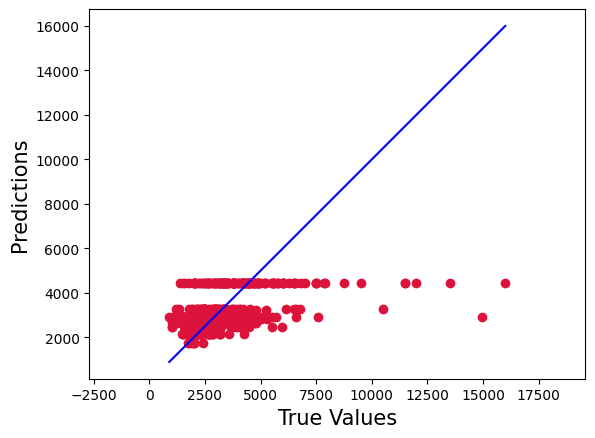

In [103]:
FIGURES_PATH = config["evaluate"]["figures_path"]

plot = plot_actual_vs_predicted(
    actual=y_test.to_numpy(),
    predicted=predicted
)

plt.savefig(FIGURES_PATH)
plt.show()

In [104]:
METRICS_PATH = config["evaluate"]["metrics_path"]

metrics = {
    "mae": mean_absolute_error(y_test.to_numpy(), predicted),
    "mse": mean_squared_error(y_test.to_numpy(), predicted),
}

with open(METRICS_PATH, "w") as f:
    json.dump(
        metrics,
        f,
        indent=4
    )